In [21]:
# initialization
import numpy as np
import pandas as pd

# importing Qiskit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [17]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

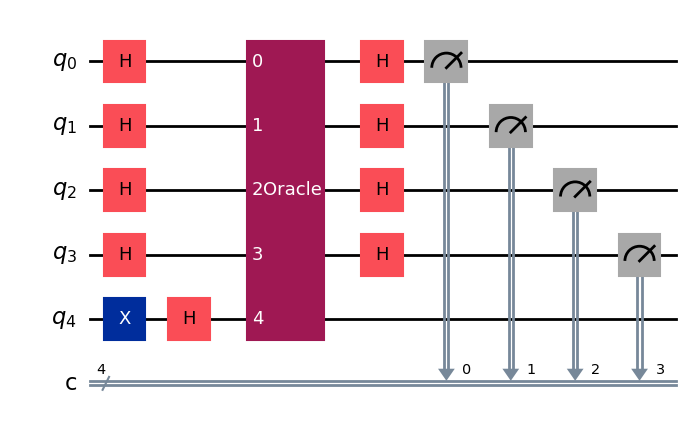

In [18]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw("mpl")

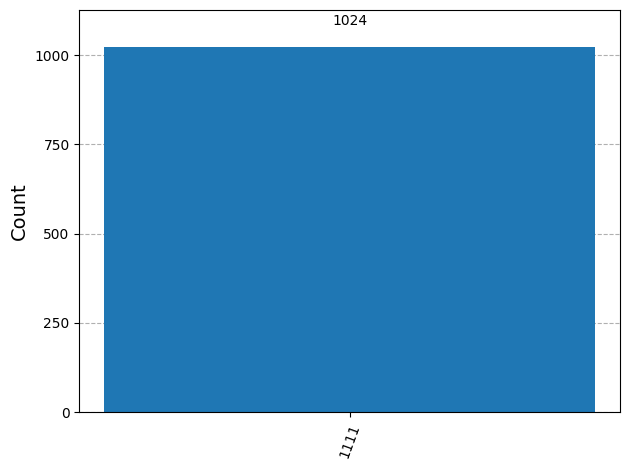

In [20]:
aer_sim = AerSimulator()
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

Using backend: ibm_torino
depth: 16 CX count: 0
Finished run


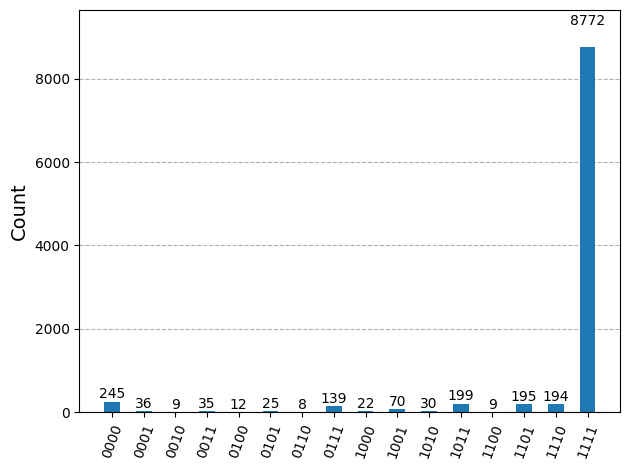

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Authenticate (replace with your IBM Quantum API token if needed)
# service = QiskitRuntimeService(channel="ibm_quantum", token="YOUR_API_TOKEN")
service = QiskitRuntimeService()  # Assumes you are already logged in via qiskit-ibm-provider

# Choose a backend (real device or simulator)
# backend = service.backend('ibmq_qasm_simulator')
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")

# Transpile circuit for the backend
transpiled_qc = transpile(
    dj_circuit,
    backend=backend,
    optimization_level=3,
    # layout_method='sabre',
    # routing_method='sabre',
    # seed_transpiler=42
)
print("depth:", transpiled_qc.depth(), "CX count:", transpiled_qc.count_ops().get('cx', 0))

# Submit job using Qiskit Runtime Sampler
sampler = Sampler(mode=backend)
job = sampler.run([transpiled_qc], shots=10000)
result = job.result()
print("Finished run")

answer = results[0].data.c.get_counts()
plot_histogram(answer)